In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

!pip install shap
import shap

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Update path as necessary
df = pd.read_csv("/content/drive/MyDrive/DS4B/California/california.csv")

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


In [ ]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [5]:
# Check for null values
null_values = df['median_house_value'].isnull().sum()

# Check for zero values
zero_values = (df['median_house_value'] == 0).sum()

print("Number of null values in 'median_house_value':", null_values)
print("Number of zero values in 'median_house_value':", zero_values)

Number of null values in 'median_house_value': 0
Number of zero values in 'median_house_value': 0


In [6]:
missing_values = df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Percentage of missing values per column:")
print(missing_values)

Percentage of missing values per column:
total_bedrooms    1.002907
dtype: float64


In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
# Select numerical and categorical variables
numerical_vars = df.select_dtypes(include=['int64', 'float64'])
categorical_vars = df.select_dtypes(exclude=['int64', 'float64'])

# Fill missing values with the mean of each numerical column
numerical_vars.fillna(numerical_vars.mean(), inplace=True)

# Perform one hot encoding for categorical variables
encoded_categorical_vars = pd.get_dummies(categorical_vars, drop_first=True, dtype=int)

# Combine numerical and one hot encoded categorical variables back into one DataFrame
cleaned_df = pd.concat([numerical_vars, encoded_categorical_vars], axis=1)

# Show the cleaned DataFrame
cleaned_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,0,0,1,0
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,0,0,1,0
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,0,0,1,0
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,0,0,1,0
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,1,0,0,0
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,1,0,0,0
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,1,0,0,0
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,1,0,0,0


In [10]:
# Drop the columns 'longitude' and 'latitude'
cleaned_df.drop(columns=['longitude', 'latitude'], inplace=True)


In [11]:
# Separate features (X) and target variable (y)
X = cleaned_df.drop('median_house_value', axis=1)
y = cleaned_df['median_house_value']

# Initialize the scaler and scale features (X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features (X) back to a DataFrame and add the target variable (y)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df['median_house_value'] = y

In [12]:
X_scaled_df

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.0,0.0,1.0,0.0,452600
1,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.0,0.0,1.0,0.0,358500
2,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.0,0.0,1.0,0.0,352100
3,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.0,0.0,1.0,0.0,341300
4,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.0,0.0,1.0,0.0,342200
...,...,...,...,...,...,...,...,...,...,...,...
20635,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130,1.0,0.0,0.0,0.0,78100
20636,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853,1.0,0.0,0.0,0.0,77100
20637,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764,1.0,0.0,0.0,0.0,92300
20638,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295,1.0,0.0,0.0,0.0,84700


In [18]:
# Separate features (X) and target variable (y)
X = X_scaled_df.drop('median_house_value', axis=1)
y = X_scaled_df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1]
# }


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.0005, 0.001, 0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters:", grid_search.best_params_)
print("Best model:", grid_search.best_estimator_)

# Predict using the best model
y_pred = grid_search.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# Initialize the XGBoost regressor with the best parameters
best_model = xgb.XGBRegressor(
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    n_estimators=grid_search.best_params_['n_estimators'],
    subsample=grid_search.best_params_['subsample'],
    objective='reg:squarederror'
)

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred_best = best_model.predict(X_test)

# Calculate RMSE for the best model
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
print(f"Best Model RMSE: {rmse_best}")

# Calculate R-squared for the best model
r_squared_best = r2_score(y_test, y_pred_best)
print(f"Best Model R-squared: {r_squared_best}")


Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
RMSE: 61945.61534654416
Best Model RMSE: 61945.61534654416
Best

In [15]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances along with corresponding column names
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 3 most important features
top_5_features = feature_importance_df.head(5)
print("Top 5 Most Important Features:")
print(top_5_features)


Top 5 Most Important Features:
                      Feature  Importance
6      ocean_proximity_INLAND    0.456539
5               median_income    0.316222
0          housing_median_age    0.044996
2              total_bedrooms    0.040495
9  ocean_proximity_NEAR OCEAN    0.035007


 96%|=================== | 3983/4128 [00:22<00:00]       

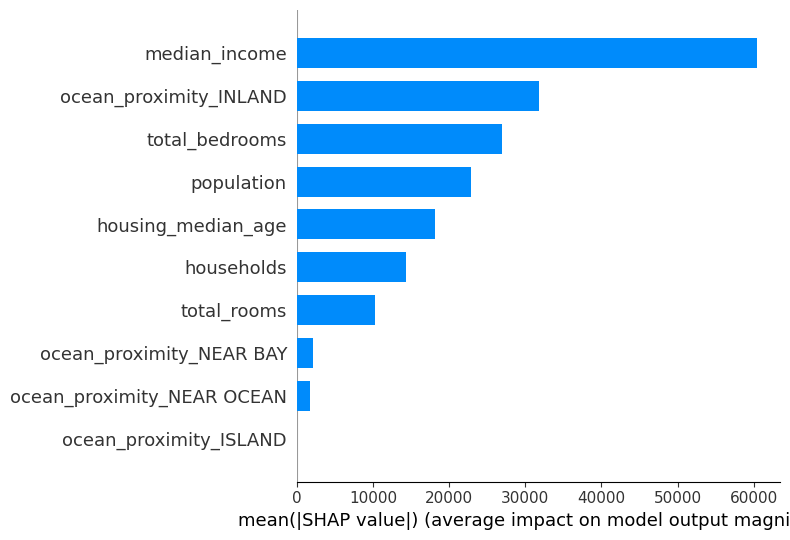

In [19]:
# Create an explainer object using the trained XGBoost model
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values for all observations in the test set
shap_values = explainer.shap_values(X_test)

# Summarize the SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")
